In [5]:
import pandas as pd

from torchvision.io import read_image

import matplotlib.pyplot as plt

import SimpleITK as sitk

import cv2

In [6]:
def plot_sample_data(sample, slide=80):
    
    kps_i = np.zeros(sample['scan_i'][:, :, slide].shape)
    kps_e = np.zeros(sample['scan_e'][:, :, slide].shape)
    
    for kp in sample['kps_i'][sample['kps_i'][:, 2] == slide]:
        kps_i[int(kp[1]), int(kp[0])] = 1
    for kp in sample['kps_e'][sample['kps_e'][:, 2] == slide]:
        kps_e[int(kp[1]), int(kp[0])] = 1
    
    
    fig, axs = plt.subplots(3,2, figsize=(10,10))
    axs[0,0].imshow(sample['scan_i'][:, :, slide], cmap='gray')
    axs[0,1].imshow(sample['scan_e'][:,:, slide], cmap='gray')
    axs[1,0].imshow(sample['mask_i'][:,:, slide], cmap='gray')
    axs[1,1].imshow(sample['mask_e'][:,:, slide], cmap='gray')
    axs[2,0].imshow(kps_i, cmap='gray')
    axs[2,1].imshow(kps_e, cmap='gray')
    axs[0, 0].axis('off')
    axs[0, 1].axis('off')
    axs[1, 0].axis('off')
    axs[1, 1].axis('off')
    axs[2, 0].axis('off')
    axs[2, 1].axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from typing import List
import struct

import nibabel as nib
import csv


# TODO: Add MIND images/features???
# TODO: specific data preprocessing for different datasets 

class LungDatasets(Dataset):
    def __init__(self, sources, root_dir:Path,
                 partitions: List[str] = ['train', 'val'],
                 transform=None):
        self.sources = sources
        self.root_dir = root_dir
        self.partitions = partitions
        self.transform = transform
        
        
        self.get_image_paths()

    def __len__(self):
        total_images = 0
        for part in self.partitions:
            for source in self.sources:
                split_path = self.root_dir/f'{source}/{part}_cases.txt'
                if not split_path.exists():
                    raise ValueError(f'Partition {part} not found for {source} in {self.root_dir}')
                with open(split_path, 'r') as f:
                    cases = f.readlines()
                    total_images += len(cases)
        return total_images
    
    
    def __getitem__(self, idx):
        
        # retrieve some metadata
        sample = {'idx':idx}
        dataset = self.image_paths['scan_i'][idx].parent.parent.name
        case =  self.image_paths['scan_i'][idx].name[:8]
        sample['dataset'] = dataset
        sample['case'] = case
        
        # load images
        sample['scan_i'] = torch.from_numpy(nib.load(self.image_paths['scan_i'][idx]).get_fdata()).float()
        sample['scan_e'] = torch.from_numpy(nib.load(self.image_paths['scan_e'][idx]).get_fdata()).float()
        sample['mask_i'] = torch.from_numpy(nib.load(self.image_paths['mask_i'][idx]).get_fdata()).float()
        sample['mask_e'] = torch.from_numpy(nib.load(self.image_paths['mask_e'][idx]).get_fdata()).float()

        # if dataset == 'learn2reg':
        # load keypoints
        corrfield = torch.empty(0,6)
        with open(self.image_paths['kps'][idx], newline='') as csvfile:
            fread = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in fread:
                corrfield = torch.cat((corrfield,torch.from_numpy(np.array(row).astype('float32')).float().view(1,6)),0)
        
        # if dataset == 'empire10':        
        #     # load keypoints
        #     with open(self.image_paths['kps'][idx], 'rb') as content_file:
        #         content = content_file.read()
        #     corrfield = torch.from_numpy(np.array(struct.unpack('f'*(len(content)//4),content))).reshape(-1,6).float()
            
        
        # NOT SURE ABOUT WHY RESCALE
        # sample['keypts_fix'] = torch.stack((corrfield[:,2+0]/207*2-1,corrfield[:,1+0]/191*2-1,corrfield[:,0+0]/191*2-1),1)
        # sample['keypts_mov'] = torch.stack((corrfield[:,2+3]/207*2-1,corrfield[:,1+3]/191*2-1,corrfield[:,0+3]/191*2-1),1)        

        
        # keypoints format same across dataset so just reorder
        sample['kps_e'] = torch.stack((corrfield[:,2],
                                       corrfield[:,1],
                                       corrfield[:,0]),1)
        
        sample['kps_i'] = torch.stack((corrfield[:,5],
                                       corrfield[:,4],
                                       corrfield[:,3]),1)     
        
        return sample
    
    
    def get_image_paths(self):
        self.image_paths = {'scan_i':[], 'scan_e':[],
                            'mask_i':[], 'mask_e':[],
                            'kps':[]}
        
        for part in self.partitions:
            for source in self.sources:
                split_path = self.root_dir/f'{source}/{part}_cases.txt'
                
                if not split_path.exists():
                    raise ValueError(f'Partition {part} not found for {source} in {self.root_dir}')
                
                with open(split_path, 'r') as f:
                    
                    cases = [x.strip() for x in f.readlines()]
                    
                    for case in cases:
                        self.image_paths['scan_i'].append(self.root_dir/f'{source}/scans/{case}_insp.nii.gz')
                        self.image_paths['scan_e'].append(self.root_dir/f'{source}/scans/{case}_exp.nii.gz')
                        self.image_paths['mask_i'].append(self.root_dir/f'{source}/lungMasks/{case}_insp.nii.gz')
                        self.image_paths['mask_e'].append(self.root_dir/f'{source}/lungMasks/{case}_exp.nii.gz')
                        self.image_paths['kps'].append(self.root_dir/f'{source}/keypoints/{case}.csv')
        
        # check that all paths exist
        for k in self.image_paths.keys():
            for p in self.image_paths[k]:
                try:
                    assert p.exists()
                except AssertionError:
                    raise ValueError(f'Path {p} does not exist')

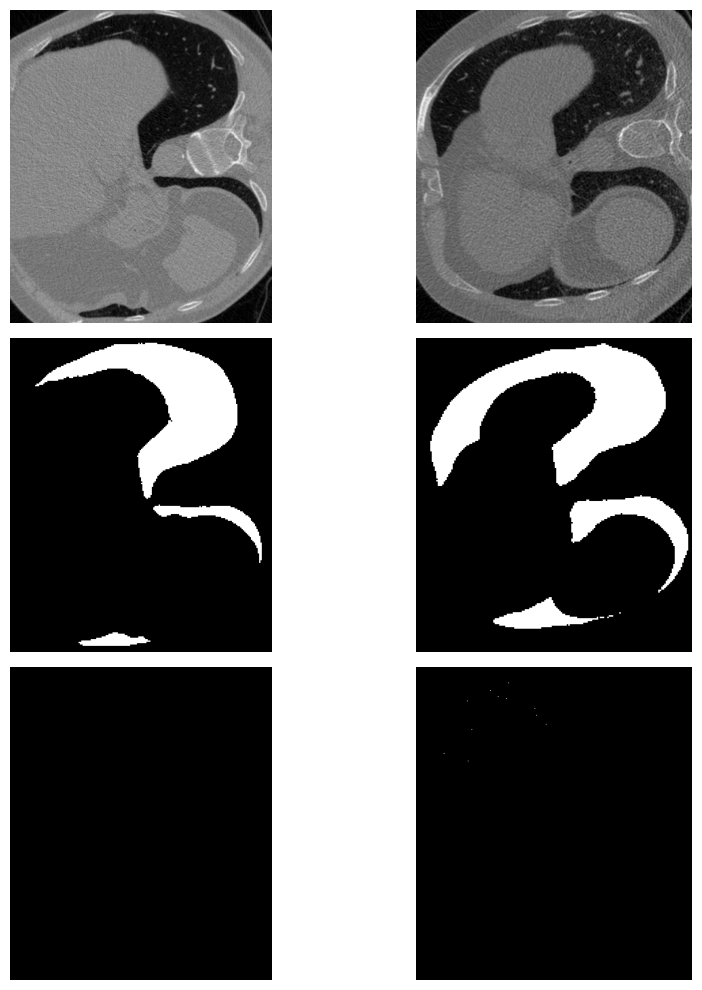

In [11]:
data = LungDatasets(sources=['empire10'], root_dir=Path('data'), partitions=['train'])
s = data[5]
# s['keypts_mov']
# s['case']
plot_sample_data(s, slide=80)

In [25]:
sizes_l2r = {s['idx']:(s['scan_i'].shape, s['scan_e'].shape) for s in data }

In [27]:
sizes_l2r_df = pd.DataFrame(sizes_l2r).T
sizes_l2r_df.columns = ['inhale', 'exhale']
sizes_l2r_df

,inhale,exhale
0,"(192, 192, 208)","(192, 192, 208)"
1,"(192, 192, 208)","(192, 192, 208)"
2,"(192, 192, 208)","(192, 192, 208)"
3,"(192, 192, 208)","(192, 192, 208)"
4,"(192, 192, 208)","(192, 192, 208)"
5,"(192, 192, 208)","(192, 192, 208)"
6,"(192, 192, 208)","(192, 192, 208)"
7,"(192, 192, 208)","(192, 192, 208)"
8,"(192, 192, 208)","(192, 192, 208)"
9,"(192, 192, 208)","(192, 192, 208)"


data/empire10/scans/case_001_insp.nii.gz
(462, 386, 412)


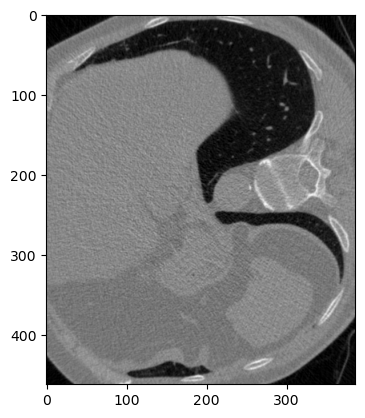

In [13]:
nib_image = nib.load(data.image_paths['scan_i'][s['idx']]).get_fdata()
print(data.image_paths['scan_i'][s['idx']])
print(nib_image.shape)
plt.imshow(nib_image[:, :, 80], cmap='gray')

In [12]:
print(s['scan_i'].shape, s['scan_e'].shape)

torch.Size([462, 386, 412]) torch.Size([418, 368, 323])


In [6]:
def min_max_norm(img: np.ndarray, max_val: int = None):
    """
    Scales images to be in range [0, 2**bits]
    Args:
        img (np.ndarray): Image to be scaled.
        max_val (int, optional): Value to scale images
            to after normalization. Defaults to None.
    Returns:
        np.ndarray: Scaled image with values from [0, max_val]
    """
    if max_val is None:
        max_val = np.iinfo(img.dtype).max
    img = (img - img.min()) / (img.max() - img.min()) * max_val
    return img

In [11]:
s['scan_i'].numpy().shape

(462, 386, 412)

Inhale kp in slice: 19/2209
using idx_0 on slice: 130
Exhale kp in slice: 16/2209


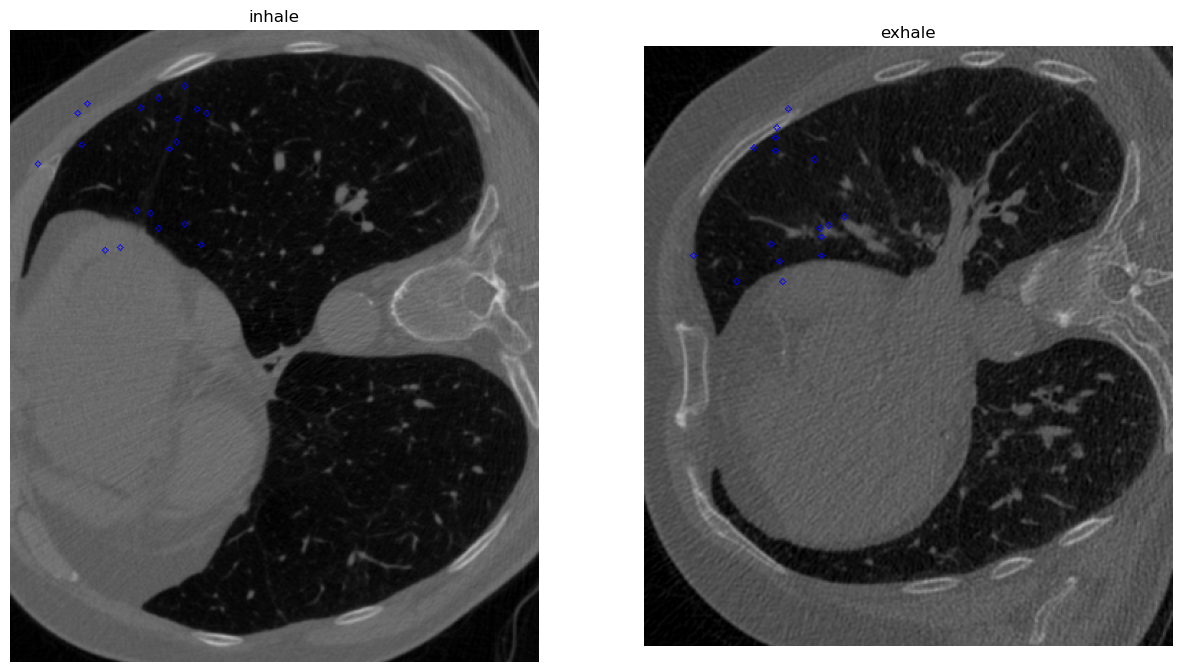

In [12]:
slice_idx = 130

# read and normalize image
norm_scan_i = min_max_norm(s['scan_i'], 255)
slice_i = norm_scan_i[:, :, slice_idx].numpy()
norm_scan_e = min_max_norm(s['scan_e'], 255)
slice_e = norm_scan_e[:, :, slice_idx].numpy()

# keypoints
kp_i = s['kps_i'].numpy()
kp_i_r = kp_i.round().astype(np.uint8)
idx_0 = kp_i_r[(kp_i_r[:, 0] == slice_idx), :]
print(f'Inhale kp in slice: {idx_0.shape[0]}/{kp_i_r.shape[0]}')

print(f'using idx_0 on slice: {slice_idx}')
slice_i = (slice_i).astype('uint8')
slice_i = cv2.cvtColor(slice_i, cv2.COLOR_GRAY2BGR)

for i in range(idx_0.shape[0]):
    cv2.circle(slice_i, (idx_0[i, 1], idx_0[i, 2]), 2, (0,0,255))
    # opencv x = col 1, y = col 2

# keypoints
kp_e = s['kps_e'].numpy()
kp_e_r = kp_e.round().astype(np.uint8)
idx_0_e = kp_e_r[(kp_e_r[:, 0] == slice_idx), :]
print(f'Exhale kp in slice: {idx_0_e.shape[0]}/{kp_e_r.shape[0]}')

# print(f'using idx_0 on slice: {slice_idx}')
slice_e = (slice_e).astype('uint8')
slice_e = cv2.cvtColor(slice_e, cv2.COLOR_GRAY2BGR)

for i in range(idx_0_e.shape[0]):
    cv2.circle(slice_e, (idx_0_e[i, 1], idx_0_e[i, 2]), 2, (0,0,255))
    # opencv x = col 1, y = col 2

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(slice_i), ax1.set_title('inhale'), ax1.axis('off')
ax2.imshow(slice_e), ax2.set_title('exhale'), ax2. axis('off')
plt.show()

In [7]:
copd_dat_files = Path().resolve()/'data/copd/keypoints/'
copd_dat_files

PosixPath('/home/alex/Documents/MAIA/udG/MIRA/mira_project/maia-mira/data/copd/keypoints')

In [11]:
import struct

for file in copd_dat_files.glob('*.dat'):

    with open(file, 'rb') as content_file:
        content = content_file.read()
    corrfield = torch.from_numpy(np.array(struct.unpack('f'*(len(content)//4),content))).reshape(-1,6).float()
    img_no = str(file.name).split('_')[1]
    print(img_no)
    # np.savetxt((copd_dat_files/f'case_0{img_no}.csv'), corrfield.numpy(), delimiter=',', fmt='%.3f')

    break


05


In [13]:
corrfield.numpy().shape

(1252, 6)

In [10]:
for path in copd_dat_files.iterdir():
    # if path.is_dir():
        print(str(path.name).split('_')[1])

05
02
05
07
01
09
03
09
08
07
06
08
10
06
02
03
10
04
04


In [7]:
kp_i = s['kps_i'].numpy()
kp_i_r = kp_i.round().astype(np.uint8)
kp_i_r

array([[121,  96,  29],
       [128,  95,  28],
       [118, 101,  30],
       ...,
       [102,  99, 154],
       [132,  91, 158],
       [108,  94, 156]], dtype=uint8)

In [8]:
idx_0 = kp_i_r[(kp_i_r[:, 0] == slice_idx), :]
idx_1 = kp_i_r[(kp_i_r[:, 1] == slice_idx), :]
idx_2 = kp_i_r[(kp_i_r[:, 2] == slice_idx), :]
print(idx_0.shape, idx_1.shape, idx_2.shape)

(16, 3) (22, 3) (10, 3)


In [18]:
print(f'using idx_0')
circles = ((slice/np.max(slice))*255).astype('uint8')
circles = cv2.cvtColor(circles, cv2.COLOR_GRAY2BGR)
# circles = np.zeros((slice.shape[0], slice.shape[1], 3), np.uint8)
for i in range(idx_0.shape[0]):
    cv2.circle(circles, (idx_0[i, 1], idx_0[i, 2]), 2, (0,0,255))
plt.imshow(circles)

using idx_0


TypeError: unsupported operand type(s) for /: 'type' and 'type'

using idx_1
























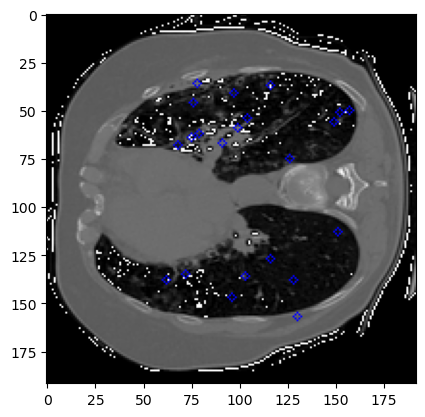

In [21]:
print(f'using idx_1')
circles = ((slice/np.max(slice))*255).astype('uint8')
circles = cv2.cvtColor(circles, cv2.COLOR_GRAY2BGR)
# circles = np.zeros((slice.shape[0], slice.shape[1], 3), np.uint8)
for i in range(idx_1.shape[0]):
    print()
    cv2.circle(circles, (idx_1[i, 0], idx_1[i, 2]), 2, (0,0,255))
plt.imshow(circles)
plt.show()

using idx_2












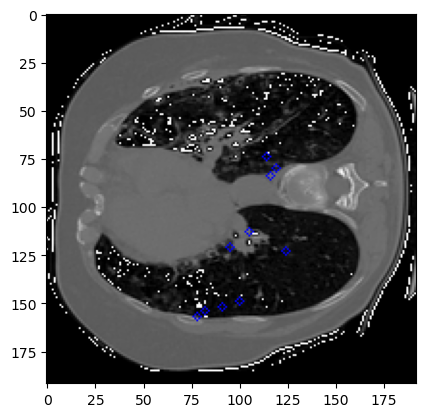

In [23]:
print(f'using idx_2')
circles = ((slice/np.max(slice))*255).astype('uint8')
circles = cv2.cvtColor(circles, cv2.COLOR_GRAY2BGR)
# circles = np.zeros((slice.shape[0], slice.shape[1], 3), np.uint8)
for i in range(idx_2.shape[0]):
    print()
    cv2.circle(circles, (idx_2[i, 1], idx_2[i, 0]), 2, (0,0,255))
plt.imshow(circles)
plt.show()